In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from dataset import LayoutDataset
from models import LayoutMLP
from scipy.stats import kendalltau

2023-11-13 23:19:10.893442: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-13 23:19:11.474166: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 128
dataset_take = 8500
learning_rate = 1.5e-3
batch_per_file_size = 8
node_embedding_size = 15
layers = [128, 64, 32, 36, 24]

dataset = LayoutDataset(
    batch_size, dataset_take,
    build_tfrecords=False,
    batch_per_file_size=batch_per_file_size
)

2023-11-13 23:19:13.772072: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 23:19:13.885377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-13 23:19:13.885620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

train layout:nlp:default 8500 False
train layout:nlp:random 8500 False
train layout:xla:random 8500 True
train layout:xla:default 8500 True
test all_filenames 10000 False
valid all_filenames 1000 False


In [3]:
mlp = LayoutMLP(
    batch_size,
    learning_rate=learning_rate,
    batch_per_file_size=batch_per_file_size,
    node_embedding_size=node_embedding_size,
    validation_frequency=10_000,
    validations_without_improvement=5,
    layer_sizes=layers,
    loss='pairwise_hinge',
    n_siblings=dataset.n_siblings,
    l1_multiplier=2e-8,
    output_name='layout_11_13_23_20'
)

In [4]:
mlp.train(dataset, None)

2023-11-13 23:21:45.435828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-13 23:21:45.463244: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f618b0f93c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-13 23:21:45.463273: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-11-13 23:21:45.481786: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-13 23:21:45.702572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-13 23:21:45.840780: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

iteration 500 training loss 3.377452 lr 0.00007
iteration 1000 training loss 3.0203595 lr 0.00015
iteration 1500 training loss 2.9243443 lr 0.00022
iteration 2000 training loss 2.2265368 lr 0.00030
iteration 2500 training loss 2.7781389 lr 0.00037
iteration 3000 training loss 2.6571593 lr 0.00045
iteration 3500 training loss 2.218255 lr 0.00052
iteration 4000 training loss 1.8362505 lr 0.00060
iteration 4500 training loss 1.9631491 lr 0.00067
iteration 5000 training loss 1.4363248 lr 0.00075
iteration 5500 training loss 2.4113045 lr 0.00082
iteration 6000 training loss 1.8716427 lr 0.00090
iteration 6500 training loss 1.716665 lr 0.00097
iteration 7000 training loss 1.9078642 lr 0.00105
iteration 7500 training loss 1.8856528 lr 0.00112
iteration 8000 training loss 1.7017523 lr 0.00120
iteration 8500 training loss 1.5117732 lr 0.00127
iteration 9000 training loss 2.179271 lr 0.00135
iteration 9500 training loss 1.4784805 lr 0.00142
iteration 10000 training loss 1.6741834 lr 0.00150
layo

iteration 70000 training loss 0.74720657 lr 0.00131
layout:nlp:random 0.9098974070961956
layout:nlp:default 0.4824440752334277
layout:xla:random 0.6080846182293184
layout:xla:default 0.31911809916312084
epoch 0, it 70000 validation loss -0.580
iteration 70500 training loss 1.3502507 lr 0.00130
iteration 71000 training loss 0.8992978 lr 0.00130
iteration 71500 training loss 1.2770748 lr 0.00130
iteration 72000 training loss 1.560768 lr 0.00129
iteration 72500 training loss 1.0356239 lr 0.00129
iteration 73000 training loss 0.96232814 lr 0.00129
iteration 73500 training loss 1.1801089 lr 0.00128
iteration 74000 training loss 1.27016 lr 0.00128
iteration 74500 training loss 1.033279 lr 0.00128
iteration 75000 training loss 1.0844228 lr 0.00128
iteration 75500 training loss 1.1199086 lr 0.00127
iteration 76000 training loss 1.4363173 lr 0.00127
iteration 76500 training loss 1.2308798 lr 0.00127
iteration 77000 training loss 1.1426319 lr 0.00126
iteration 77500 training loss 0.8527541 lr 0.

iteration 136500 training loss 0.81374264 lr 0.00077
iteration 137000 training loss 1.0970358 lr 0.00077
iteration 137500 training loss 1.0525218 lr 0.00077
iteration 138000 training loss 1.1798264 lr 0.00076
iteration 138500 training loss 1.0836688 lr 0.00076
iteration 139000 training loss 1.2644587 lr 0.00075
iteration 139500 training loss 1.1660477 lr 0.00075
iteration 140000 training loss 0.8284261 lr 0.00074
layout:nlp:random 0.930199462353583
layout:nlp:default 0.49452871349043204
layout:xla:random 0.6097213460726844
layout:xla:default 0.3409977514816077
epoch 0, it 140000 validation loss -0.594
iteration 140500 training loss 0.8710596 lr 0.00074
iteration 141000 training loss 0.9388084 lr 0.00073
iteration 141500 training loss 1.2740461 lr 0.00073
iteration 142000 training loss 1.0680034 lr 0.00072
iteration 142500 training loss 0.8853538 lr 0.00072
iteration 143000 training loss 0.8303044 lr 0.00072
iteration 143500 training loss 0.8881706 lr 0.00071
iteration 144000 training l

iteration 202500 training loss 0.9351023 lr 0.00025
iteration 203000 training loss 0.64628667 lr 0.00025
iteration 203500 training loss 1.0064933 lr 0.00025
iteration 204000 training loss 1.1626339 lr 0.00024
iteration 204500 training loss 1.1644281 lr 0.00024
iteration 205000 training loss 0.9485405 lr 0.00024
iteration 205500 training loss 1.0756457 lr 0.00024
iteration 206000 training loss 1.2125093 lr 0.00023
iteration 206500 training loss 0.9263362 lr 0.00023
iteration 207000 training loss 1.1063321 lr 0.00023
iteration 207500 training loss 1.4867134 lr 0.00022
iteration 208000 training loss 0.9631909 lr 0.00022
iteration 208500 training loss 0.875306 lr 0.00022
iteration 209000 training loss 0.93485564 lr 0.00022
iteration 209500 training loss 0.98738116 lr 0.00021
iteration 210000 training loss 0.7947851 lr 0.00021
layout:nlp:random 0.9363050604082858
layout:nlp:default 0.49266440669822187
layout:xla:random 0.6243446713245285
layout:xla:default 0.3352890477699077
epoch 0, it 210

In [5]:
mlp.best_val_subsets

{'layout:nlp:random': 0.9363050604082858,
 'layout:nlp:default': 0.49567929699211905,
 'layout:xla:random': 0.6439498632815777,
 'layout:xla:default': 0.3445227842961587}

In [6]:
np.mean(list(mlp.best_val_subsets.values()))

0.6051142512445352

## Evaluate validation set

In [7]:
val_df = mlp.predict_over_dataset(dataset.valid_data, return_labels=True)

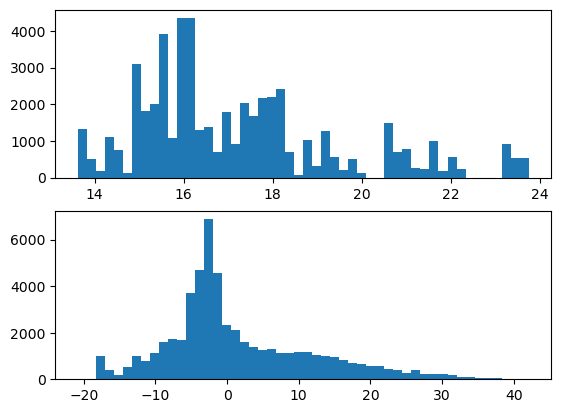

In [8]:
plt.subplot(2, 1, 1)
plt.hist(val_df['target'], bins=50)
plt.subplot(2, 1, 2)
plt.hist(val_df['prediction'], bins=50);

In [9]:
val_df.groupby('ID').apply(lambda x: x.min()).sort_values('prediction')

,ID,config_index,prediction,target
ID,,,,
b'layout:xla:random:resnet50.4x4.fp16',b'layout:xla:random:resnet50.4x4.fp16',15,-20.836464,19.288380
b'layout:nlp:random:talking-heads_large_batch_size_16_train',b'layout:nlp:random:talking-heads_large_batch_...,10,-18.402248,18.720034
b'layout:nlp:default:talking-heads_large_batch_size_16_train',b'layout:nlp:default:talking-heads_large_batch...,10,-17.952629,18.689404
b'layout:xla:default:resnet50.4x4.fp16',b'layout:xla:default:resnet50.4x4.fp16',4,-17.688612,19.288345
b'layout:xla:random:tf2_bert_pretrain_dynamic_batch_size',b'layout:xla:random:tf2_bert_pretrain_dynamic_...,14,-16.722530,17.944567
b'layout:xla:random:resnet_v1_50_official_batch_128_bf16',b'layout:xla:random:resnet_v1_50_official_batc...,19,-16.438446,20.910173
b'layout:xla:random:bert_pretraining.4x4.fp16',b'layout:xla:random:bert_pretraining.4x4.fp16',9,-15.532472,17.647587
b'layout:xla:default:bert_pretraining.4x4.fp16',b'layout:xla:default:bert_pretraining.4x4.fp16',24,-14.575588,17.647287
b'layout:xla:random:unet_3d.4x4.bf16',b'layout:xla:random:unet_3d.4x4.bf16',0,-14.216846,20.629919


Text(0.5, 1.0, "b'layout:xla:default:resnet50.4x4.fp16'")

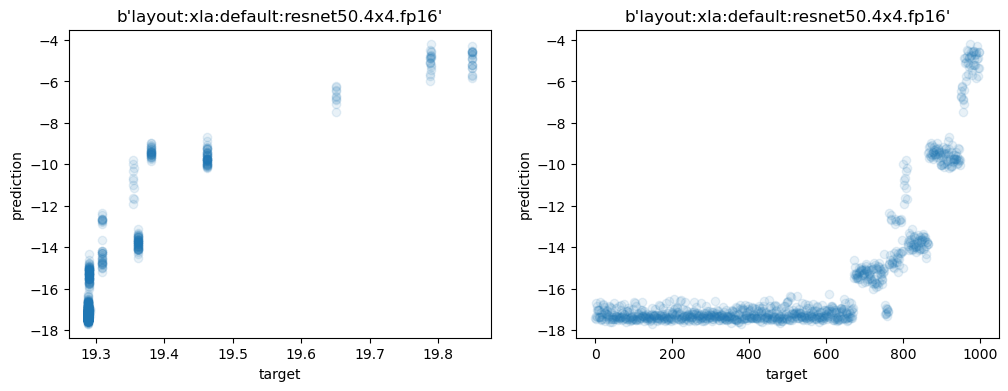

In [10]:
x_lin = np.linspace(15, 25, 100)
#plt.plot(x_lin, x_lin, color='orange')

random_sample = val_df.sample(1_000)
graph_id = np.random.choice(val_df['ID'].unique())
#graph_id = b'layout:xla:default:inception_v3_batch_128_train'
#graph_id = b'layout:xla:default:unet_3d.4x4.bf16'
random_sample = val_df[val_df['ID'] == graph_id].copy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample.target,
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

random_sample.sort_values('target', inplace=True)
plt.subplot(1, 2, 2)
plt.scatter(
    np.arange(len(random_sample)),
    np.clip(random_sample.prediction, a_min=-500.0, a_max=1000.0),
    alpha=0.1,
    #c=random_sample['ID'].apply(lambda x: x.decode('UTF-8').split(':')[1] == 'xla').values.astype(float)
)
plt.xlabel('target')
plt.ylabel('prediction')
plt.title(graph_id)
#plt.colorbar()

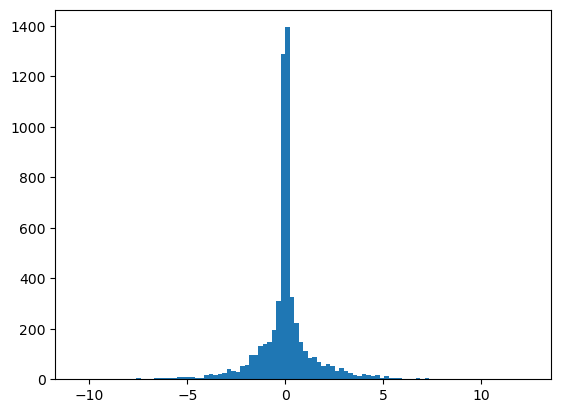

In [11]:
plt.hist(mlp.dense_layer_global_1.kernel.numpy().flatten(), bins=100);

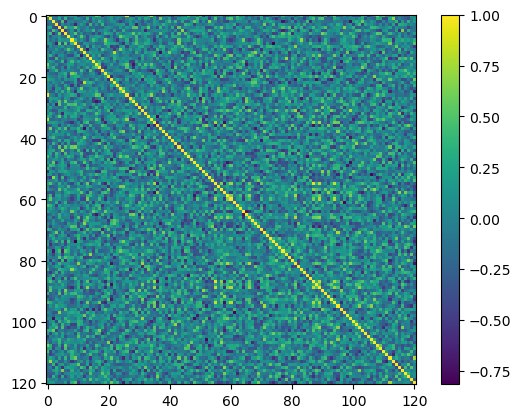

In [12]:
emb = mlp.embedding_layer_node_ops.weights[0].numpy()
emb = emb / np.expand_dims(np.linalg.norm(emb, axis=1), axis=-1)
dots = np.matmul(emb, emb.T)
plt.imshow(dots)
plt.colorbar()

In [ ]:
ind = np.unravel_index(np.argsort(dots.flatten())[-122], dots.shape)
ind

In [ ]:
val_df[val_df['ID'] == b'layout:xla:default:unet_3d.4x4.bf16'].sort_values('target')

In [ ]:
for val_batch in dataset.valid_data:
    if b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy():
        print(val_batch['layout_id'])
        break

In [ ]:
np.unique(val_batch['layout_id'].numpy())

In [ ]:
b'layout:xla:default:mlperf_bert_batch_24_2x2' in val_batch['layout_id'].numpy()

In [ ]:
random_sample = val_df.sample(5_000)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(
    random_sample['target'],
    np.abs(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('abs error')
x_lin = np.linspace(0, 0.7, 100)
#plt.plot(x_lin, x_lin, color='orange')


plt.subplot(1, 2, 2)
plt.scatter(
    random_sample['target'],
    np.square(random_sample['target'] - random_sample['prediction']),
    alpha=0.07
)
plt.xlabel('target')
plt.ylabel('squared error')

In [13]:
def sort_configs(df):
    top = df.sort_values('prediction')
    top = top['config_index'].values.tolist()
    top = [str(i) for i in top]
    return ';'.join(top)

In [14]:
val_prediction = val_df.groupby('ID').apply(sort_configs)
val_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
val_prediction

ID
layout:nlp:default:albert_en_xlarge_batch_size_16_test                               29259;10359;25654;29055;49764;10362;29075;1026...
layout:nlp:default:bert_en_cased_L-12_H-768_A-12_batch_size_16_test                  1978;31917;30862;82240;83818;31983;97182;68992...
layout:nlp:default:bert_multi_cased_L-12_H-768_A-12_batch_size_16_train              27280;27317;12810;20490;12883;22250;9114;12767...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_32_test      74984;83966;82833;11113;85675;83759;24441;8738...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-128_A-2_batch_size_64_train     34422;34483;34502;41651;29601;11233;24814;5115...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_32_test      72351;53677;52465;36698;23799;31366;57619;3823...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train     10164;10207;1065;35676;1043;15308;43109;22931;...
layout:nlp:default:small_bert_bert_en_uncased_L-10_H

In [15]:
val_df

,ID,config_index,prediction,target
0,b'layout:nlp:default:small_bert_bert_en_uncase...,54409,-3.591649,15.302357
1,b'layout:nlp:random:talking-heads_large_batch_...,2422,3.212388,19.289913
2,b'layout:nlp:random:bert_multi_cased_L-12_H-76...,4599,-8.102306,17.439354
3,b'layout:nlp:random:small_bert_bert_en_uncased...,88489,8.720711,16.119314
4,b'layout:nlp:random:small_bert_bert_en_uncased...,10197,33.685226,17.433710
...,...,...,...,...
53476,b'layout:xla:random:resnet50.4x4.fp16',2618,0.902716,19.914824
53477,b'layout:nlp:default:small_bert_bert_en_uncase...,12156,0.090891,15.954149
53478,b'layout:nlp:random:small_bert_bert_en_uncased...,29637,13.113008,17.357023
53479,b'layout:xla:default:unet_3d.4x4.bf16',1562,-6.308642,20.629971


In [16]:
val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3])).unique()

array(['layout:nlp:default', 'layout:nlp:random', 'layout:xla:random',
       'layout:xla:default'], dtype=object)

In [17]:
def compute_layout_score_group(df):
    score, _ = kendalltau(df['prediction'], df['target'])
    return score

val_df['subset'] = val_df['ID'].map(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
all_means = []
for subset in val_df['subset'].unique():
    mean = np.mean(val_df[val_df['subset'] == subset].groupby('ID').apply(compute_layout_score_group))
    all_means.append(mean)
    print(subset, mean)
print(np.mean(all_means))

layout:nlp:default 0.49266440669822187
layout:nlp:random 0.9363050604082858
layout:xla:random 0.6243446713245285
layout:xla:default 0.3352890477699077
0.597150796550236


In [ ]:
np.mean([
    0.9235,
    0.6591,
    0.516,
    0.358,
    0.968
])

In [18]:
val_scores = val_df.groupby('ID').apply(compute_layout_score_group)
val_scores.sort_values()

ID
b'layout:xla:default:unet_3d.4x4.bf16'                                                  0.004597
b'layout:xla:random:unet_3d.4x4.bf16'                                                   0.171592
b'layout:xla:default:mlperf_bert_batch_24_2x2'                                          0.235990
b'layout:xla:default:resnet_v1_50_official_batch_128_bf16'                              0.273605
b'layout:xla:default:tf2_bert_pretrain_dynamic_batch_size'                              0.359063
b'layout:nlp:default:small_bert_bert_en_uncased_L-4_H-512_A-8_batch_size_32_train'      0.375822
b'layout:xla:random:mlperf_bert_batch_24_2x2'                                           0.385081
b'layout:nlp:default:small_bert_bert_en_uncased_L-10_H-256_A-4_batch_size_64_train'     0.425269
b'layout:xla:random:inception_v3_batch_128_train'                                       0.428458
b'layout:xla:default:inception_v3_batch_128_train'                                      0.438618
b'layout:nlp:default:small_

In [ ]:
valid_nodes_list = []
for batch in dataset.valid_data:
    df = pd.DataFrame(
        np.stack([
            batch['layout_id'].numpy(), 
            batch['valid_nodes'].numpy()], axis=-1),
        columns=['ID', 'valid_nodes']
    ).drop_duplicates('ID')
    valid_nodes_list.append(df)
valid_nodes = pd.concat(valid_nodes_list).drop_duplicates('ID')
valid_nodes

In [ ]:
valid_nodes.set_index('ID', inplace=True)
valid_nodes['scores'] = val_scores
valid_nodes

In [ ]:
valid_nodes.reset_index(inplace=True)
valid_nodes

In [ ]:
valid_nodes['subset'] = valid_nodes['ID'].apply(lambda x: ':'.join(x.decode('UTF-8').split(':')[:3]))
valid_nodes

In [ ]:
plt.scatter(
    valid_nodes['scores'],
    valid_nodes['valid_nodes']
)

In [ ]:
subset = 'layout:xla:random'
valid_nodes_subset = valid_nodes[valid_nodes['subset'] == subset]
print(valid_nodes_subset.sort_values('valid_nodes').iloc[-1])
plt.scatter(
    valid_nodes_subset['scores'],
    valid_nodes_subset['valid_nodes']
)

In [ ]:
def layout_score(candidate_order, layout_dict):
    runtimes = layout_dict['config_runtime']
    best_ranking = np.argsort(runtimes)
    assert len(candidate_order) == len(runtimes)
    score, _ = kendalltau(candidate_order, best_ranking)
    return score

In [ ]:
dirpath, filename

In [ ]:
true_order = np.argsort(layout_dict['config_runtime'])
plt.scatter(true_order, candidate_order)

In [ ]:
layout_set = 'valid'
true_orders = []
layout_ids = []
for dirpath, dirnames, filenames in os.walk('predict-ai-model-runtime/npz_all/npz/layout'):
    if len(filenames) == 0:
        continue
    
    if dirpath.split('/')[-1] != layout_set:
        continue
        
    layout_id_prefix = ':'.join(dirpath.split('/')[-4:-1])
    for filename in os.listdir(dirpath):
        print(filename)
        layout_id = layout_id_prefix+':'+filename[:-4]
        layout_dict = dict(np.load(os.path.join(dirpath, filename)))
        runtimes = layout_dict['config_runtime']
        best_ranking = np.argsort(runtimes)
        best_ranking = ';'.join([str(i) for i in best_ranking])
        true_orders.append(best_ranking)
        layout_ids.append(layout_id)
        
true_order_df = pd.DataFrame(
    data=np.stack([layout_ids, true_orders], axis=-1),
    columns=['ID', 'true_order']
)
true_order_df

In [ ]:
# layout_id = true_order_df.sample()['ID'].values[0]
layout_id = 'layout:xla:default:resnet50.4x4.fp16'
true_order = [int(i) for i in true_order_df[true_order_df['ID'] == layout_id]['true_order'].values[0].split(';')]
candidate_order = [int(i) for i in val_prediction[layout_id].split(';')]

plt.scatter(true_order, candidate_order)
plt.xlabel('true order')
plt.ylabel('candidate order')
plt.title(f'{layout_id}, len {len(true_order)}')

In [ ]:
layout_dict = dict(np.load('predict-ai-model-runtime/npz_all/npz/layout/nlp/default/valid/small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train.npz'))
layout_dict['node_config_feat'].shape

In [ ]:
val_df[val_df['ID'] == b'layout:nlp:default:small_bert_bert_en_uncased_L-6_H-256_A-4_batch_size_16_train']

In [ ]:
evaluation_result_layout['score'].astype(float).mean()

## Inference over test set

In [19]:
test_df = mlp.predict_over_dataset(dataset.test_data, return_labels=False)
test_df

,ID,config_index,prediction
0,b'layout:nlp:random:38524e2ff135ded55b5286407e...,0,-0.640005
1,b'layout:xla:random:fbaa8bb6a1aed9988281085c91...,0,-7.870991
2,b'layout:xla:default:db59a991b7c607634f13570d5...,0,-9.550020
3,b'layout:nlp:random:d15316c12eefdef1ba549eb433...,0,4.982302
4,b'layout:nlp:random:29886a50d55cfe77a9497bc906...,0,19.118301
...,...,...,...
49997,b'layout:nlp:default:58cc2e418c3a8a19b871e1596...,999,-2.354733
49998,b'layout:nlp:default:492c7a94d559aa4a88769142d...,999,-0.363242
49999,b'layout:nlp:random:7f6284ebe027b1e9a3850fc703...,999,16.222902
50000,b'layout:nlp:default:3a0c5517a87df8d82fd637b83...,1000,-17.225698


In [20]:
test_df.groupby('ID').count()

,config_index,prediction
ID,,
b'layout:nlp:default:016ac66a44a906a695afd2228509046a',1000,1000
b'layout:nlp:default:171b0513d8874a427ccfa46d136fbadc',1000,1000
b'layout:nlp:default:23559853d9702baaaacbb0c83fd32266',1000,1000
b'layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9',1000,1000
b'layout:nlp:default:32531d07a084b319dce484f53a4cf3fc',1000,1000
b'layout:nlp:default:38524e2ff135ded55b5286407e7af6b7',1000,1000
b'layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba',1001,1001
b'layout:nlp:default:492c7a94d559aa4a88769142d2a68362',1000,1000
b'layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad',1000,1000


In [21]:
test_prediction = test_df.groupby('ID').apply(sort_configs)
test_prediction.rename(index=lambda x: x.decode('UTF-8'), inplace=True)
test_prediction

ID
layout:nlp:default:016ac66a44a906a695afd2228509046a    83;338;54;797;192;156;416;871;380;515;993;525;...
layout:nlp:default:171b0513d8874a427ccfa46d136fbadc    21;888;942;351;400;727;276;404;808;453;359;22;...
layout:nlp:default:23559853d9702baaaacbb0c83fd32266    899;48;664;350;768;716;987;220;943;487;724;142...
layout:nlp:default:29886a50d55cfe77a9497bc906c76ce9    481;451;70;104;910;750;284;669;361;118;183;61;...
layout:nlp:default:32531d07a084b319dce484f53a4cf3fc    151;26;234;372;877;369;71;160;301;64;979;290;6...
layout:nlp:default:38524e2ff135ded55b5286407e7af6b7    157;45;458;203;635;768;809;216;944;109;165;764...
layout:nlp:default:3a0c5517a87df8d82fd637b83298a3ba    699;464;418;425;502;621;623;423;924;655;905;49...
layout:nlp:default:492c7a94d559aa4a88769142d2a68362    236;62;69;545;461;807;217;943;759;885;748;305;...
layout:nlp:default:58cc2e418c3a8a19b871e15964b534ad    244;996;977;220;800;258;369;676;43;975;170;381...
layout:nlp:default:60880ed76de53f4d7a1b960b24f20f7d 

In [22]:
test_prediction = pd.DataFrame(test_prediction, columns=['TopConfigs']).reset_index()
test_prediction

,ID,TopConfigs
0,layout:nlp:default:016ac66a44a906a695afd222850...,83;338;54;797;192;156;416;871;380;515;993;525;...
1,layout:nlp:default:171b0513d8874a427ccfa46d136...,21;888;942;351;400;727;276;404;808;453;359;22;...
2,layout:nlp:default:23559853d9702baaaacbb0c83fd...,899;48;664;350;768;716;987;220;943;487;724;142...
3,layout:nlp:default:29886a50d55cfe77a9497bc906c...,481;451;70;104;910;750;284;669;361;118;183;61;...
4,layout:nlp:default:32531d07a084b319dce484f53a4...,151;26;234;372;877;369;71;160;301;64;979;290;6...
5,layout:nlp:default:38524e2ff135ded55b5286407e7...,157;45;458;203;635;768;809;216;944;109;165;764...
6,layout:nlp:default:3a0c5517a87df8d82fd637b8329...,699;464;418;425;502;621;623;423;924;655;905;49...
7,layout:nlp:default:492c7a94d559aa4a88769142d2a...,236;62;69;545;461;807;217;943;759;885;748;305;...
8,layout:nlp:default:58cc2e418c3a8a19b871e15964b...,244;996;977;220;800;258;369;676;43;975;170;381...
9,layout:nlp:default:60880ed76de53f4d7a1b960b24f...,579;662;481;246;440;623;69;538;43;796;304;251;...


In [23]:
test_prediction['subset'] = test_prediction['ID'].apply(lambda x:':'.join(x.split(':')[:3]))

In [24]:
subset = 'layout:xla:default'
test_prediction[test_prediction['subset'] == subset]

,ID,TopConfigs,subset
34,layout:xla:default:05ae41e26dd3c4c06390371a042...,913;450;870;894;646;96;58;849;254;965;485;358;...,layout:xla:default
35,layout:xla:default:3e7156ac468dfb75cf5c9615e1e...,853;234;782;671;590;809;862;887;541;504;310;53...,layout:xla:default
36,layout:xla:default:5335ed13823b0a518ee3c79ba44...,370;734;776;508;504;45;207;582;266;806;821;709...,layout:xla:default
37,layout:xla:default:937ee0eb0d5d6151b7b8252933b...,690;729;38;79;937;633;256;777;800;78;668;616;1...,layout:xla:default
38,layout:xla:default:cd708819d3f5103afd6460b15e7...,987;347;783;189;332;133;198;831;707;381;231;81...,layout:xla:default
39,layout:xla:default:db59a991b7c607634f13570d52c...,983;132;415;55;816;381;388;291;927;358;696;661...,layout:xla:default
40,layout:xla:default:e8a3a1401b5e79f66d7037e424f...,465;966;901;343;90;861;260;407;929;964;419;994...,layout:xla:default
41,layout:xla:default:fbaa8bb6a1aed9988281085c910...,894;197;551;641;261;575;497;212;437;492;490;34...,layout:xla:default


In [25]:
pd.DataFrame(test_prediction, columns=['TopConfigs']).to_csv('predictions/layout_final_test_prediction_11_13_23_20.csv')